This file runs split-half consistency analyses on the gaze locations collected on the CodeCharts1K dataset and reported in Fosco, Newman, et al. (CVPR 2020), including: Section 4 in the main paper, and Section 2 in the supplemental material.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os
from PIL import Image
import importlib
from collections import Counter
import math
import visualization_functions as sp
import matplotlib.cm as cm
import glob
cm_hot = cm.get_cmap('hot')
import operator
from tqdm import tqdm
import pickle
import pandas as pd
import seaborn as sn
import matplotlib.patches as patches
from scipy import stats

In [2]:
times = ['500','3000','5000']
datapath = 'CodeCharts1k/' # our dataset, containing images and gaze locations
imdir = os.path.join(datapath,'raw_img')
rerun = False # if you want to re-run the analyses (takes loooong...)
aggregate_splits = True # read off all splits computed and average results

In [3]:
def compute_splithalf_consistency(datapath,files,times,imdir):

    todebug = False
    CC_scores = {}

    for i in tqdm(range(len(files)), position=0, leave=True): # progress bar
        
        curfilename = files[i];
        imname = curfilename.split('.')[0]+'.jpg';

        for t1 in range(len(times)):

            time1 = times[t1]
            
            # load the gaze locations for this image
            with open(os.path.join(datapath,'fix_coords',time1,curfilename)) as f:
                coords1 = json.load(f)
                
            # get a random half of gaze locations for this image at duration time1
            perm = np.random.permutation(len(coords1))
            Nhalf = math.floor(len(coords1)/2.0)
            coords_firstHalf = [coords1[perm[ii]] for ii in range(Nhalf)]
            
            # compute a heatmap from them
            res1,im = sf.get_heatmap_for_coords(imname,coords_firstHalf,imdir,sigma=50,toplot=False)

            for t2 in range(t1,len(times)):

                time2 = times[t2]

                # for computing split-half consistency from same duration, use the
                # other half of the participants' gaze locations
                if t2==t1:
                    coords_secHalf = [coords1[perm[Nhalf+ii]] for ii in range(Nhalf)]
                    
                # otherwise, sample another random half of gaze locations from 
                # another duration time2
                else: 
                    with open(os.path.join(datapath,'fix_coords',time2,curfilename)) as f:
                        coords2 = json.load(f)
                    perm = np.random.permutation(len(coords2))
                    Nhalf = math.floor(len(coords2)/2.0)
                    coords_secHalf = [coords2[perm[ii]] for ii in range(Nhalf)]

                # compute heatmap from them
                res2,im = sf.get_heatmap_for_coords(imname,coords_secHalf,imdir,sigma=50,toplot=False)

                # compute pearson's correlation coefficient of the two heatmaps
                cct = sf.cc(res1,res2);

                if todebug:
                    print('%s vs %s: CC=%2.2f'%(time1,time2,cct))

                # fill in the entries of the correlation matrix
                if (t1,t2) not in CC_scores.keys():
                    CC_scores[(t1,t2)] = [None]*len(files)
                CC_scores[(t1,t2)][i] = cct;
     
    return CC_scores


def plot_confusion_matrix(CC_scores,times):

    # generate confusion matrix
    M = np.zeros((len(times),len(times)))
    for k in CC_scores.keys():
        scores = [elt for elt in CC_scores[k] if elt is not None]
        # fill in symmetric entries:
        M[k[0],k[1]] = np.mean(scores)
        M[k[1],k[0]] = np.mean(scores) 

    df_cm = pd.DataFrame(M, index = [i for i in times],
                      columns = [i for i in times])
    plt.figure(figsize = (6,6))
    sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, vmin=0.5, vmax=1.0, square=True, \
              cbar_kws={"orientation": "horizontal"}) # Blues
    sn.set(font_scale=1.2)
    plt.show()

    return M

def compute_and_plot_conf_matrix_from_inds(CC_scores,times,im_ids,curtitle):

    M = np.zeros((len(times),len(times)))
    for k in CC_scores.keys():
        scores = [CC_scores[k][i] for i in range(len(CC_scores[k])) if i in im_ids and CC_scores[k][i] is not None]
        #print('%s: %2.3f'%(k,np.mean(scores)))
        M[k[0],k[1]] = np.mean(scores)
        M[k[1],k[0]] = np.mean(scores)  
        
    df_cm = pd.DataFrame(M, index = [i for i in times],
                  columns = [i for i in times])
    plt.figure(figsize = (6,6))
    sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, vmin=0.5, vmax=0.8, square=True, \
              cbar_kws={"orientation": "horizontal"}) # Blues
    sn.set(font_scale=1.2)
    plt.title(curtitle)
    plt.show()
    

## COCO dataset (half of CodeCharts1K) ##

In [4]:
if rerun: # required for the function calls below
    files = glob.glob(os.path.join(datapath,'fix_coords/500/*.json'))
    files_SALICON = [os.path.basename(file) for file in files if 'COCO' in file]

In [5]:
# compute the consistency scores for just a single split of data (can take a few hours...)
if rerun:
    CC_scores = compute_splithalf_consistency(datapath,files_SALICON,times,imdir)
    with open("CC_scores_splithalf_SALICON.pkl","wb") as f:
        pickle.dump(CC_scores,f)

In [6]:
# if time allows, compute multiple splits of participant data (can take more than a few hours)
if rerun:
    Nsplits = 10
    for s in range(Nsplits):
        print('On split %d/%d'%(s,Nsplits))
        CC_scores = compute_splithalf_consistency(datapath,files_SALICON,times,imdir)
        with open("CC_scores_splithalf_SALICON_split%d.pkl"%(s),"wb") as f:
            pickle.dump(CC_scores,f)

In [7]:
if rerun: # aggregate all the splits
    if aggregate_splits:
        print('On original split')
        CC_scores = pickle.load(open("CC_scores_splithalf_SALICON.pkl","rb")) # the original split
        CC_scores_by_im = {}

        Nsplits = 10
        for s in range(Nsplits):
            print('On split %d/%d'%(s,Nsplits))
            CC_scores_split = pickle.load(open("CC_scores_splithalf_SALICON_split%d.pkl"%(s),"rb"))
            for elem in CC_scores_split:
                nims = len(CC_scores_split[elem])
                if elem not in CC_scores_by_im: 
                    CC_scores_by_im[elem] = [[None]*Nsplits for i in range(nims)]
                CC_scores[elem] = [CC_scores[elem][i]+CC_scores_split[elem][i] for i in range(nims)]
                for i in range(nims):
                    CC_scores_by_im[elem][i][s] = CC_scores_split[elem][i]

        for elem in CC_scores:
            CC_scores[elem] = [val/float(Nsplits+1) for val in CC_scores[elem]]
    else:
        CC_scores = pickle.load(open("CC_scores_splithalf_SALICON.pkl","rb"))
        CC_scores_by_im = None

    CC_scores_SALICON = CC_scores.copy()
    CC_scores_by_im_SALICON = CC_scores_by_im.copy()
    
    RES = {'CC_scores_SALICON':CC_scores_SALICON,'CC_scores_by_im_SALICON':CC_scores_by_im_SALICON}

    with open("CC_scores_splithalf_SALICON_%dsplits.pkl"%(Nsplits),"wb") as f:
        pickle.dump(RES,f)


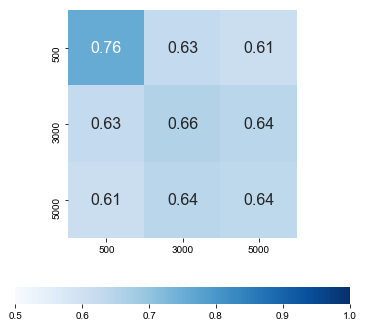

In [8]:
# read in pre-computed data and display the split-half consistency results
RES = pickle.load(open("CC_scores_splithalf_SALICON_10splits.pkl","rb"))
CC_scores_SALICON = RES['CC_scores_SALICON']
CC_scores_by_im_SALICON = RES['CC_scores_by_im_SALICON']
files_SALICON = RES['files_SALICON']

plot_confusion_matrix(CC_scores_SALICON,times)
assert(len(CC_scores_SALICON[(0,0)])==500)

## Mixed dataset (other half of CodeCharts1K) ##

In [9]:
if rerun: # required for the function calls below
    files = glob.glob(os.path.join(datapath,'fix_coords/500/*.json'))
    files_MIXED = [os.path.basename(file) for file in files if 'COCO' not in file]

In [10]:
# if time allows, compute multiple splits of participant data (can take more than a few hours)
if rerun:
    CC_scores = compute_splithalf_consistency(datapath,files_MIXED,times,imdir)
    with open("CC_scores_splithalf_MIXED.pkl","wb") as f:
        pickle.dump(CC_scores,f)

In [11]:
# if time allows, compute multiple splits of participant data (can take more than a few hours)
if rerun:
    Nsplits = 10
    for s in range(Nsplits):
        print('On split %d/%d'%(s,Nsplits))
        CC_scores = compute_splithalf_consistency(datapath,files_MIXED,times,imdir)
        with open("CC_scores_splithalf_MIXED_split%d.pkl"%(s),"wb") as f:
            pickle.dump(CC_scores,f)

In [12]:
if rerun: # aggregate all the splits
    if aggregate_splits:
        print('On original split')
        CC_scores = pickle.load(open("CC_scores_splithalf_MIXED.pkl","rb")) # the original split
        CC_scores_by_im = {}

        Nsplits = 10
        for s in range(Nsplits):
            print('On split %d/%d'%(s,Nsplits))
            CC_scores_split = pickle.load(open("CC_scores_splithalf_MIXED_split%d.pkl"%(s),"rb"))
            for elem in CC_scores_split:
                nims = len(CC_scores_split[elem])
                if elem not in CC_scores_by_im: 
                    CC_scores_by_im[elem] = [[None]*Nsplits for i in range(nims)]
                CC_scores[elem] = [CC_scores[elem][i]+CC_scores_split[elem][i] for i in range(nims)]
                for i in range(nims):
                    CC_scores_by_im[elem][i][s] = CC_scores_split[elem][i]

        for elem in CC_scores:
            CC_scores[elem] = [val/float(Nsplits+1) for val in CC_scores[elem]]
    else:
        CC_scores = pickle.load(open("CC_scores_splithalf_MIXED.pkl","rb"))
        CC_scores_by_im = None

    CC_scores_MIXED = CC_scores.copy()
    CC_scores_by_im_MIXED = CC_scores_by_im.copy()

    RES = {'CC_scores_MIXED':CC_scores_MIXED,'CC_scores_by_im_MIXED':CC_scores_by_im_MIXED}

    with open("CC_scores_splithalf_MIXED_%dsplits.pkl"%(Nsplits),"wb") as f:
        pickle.dump(RES,f)

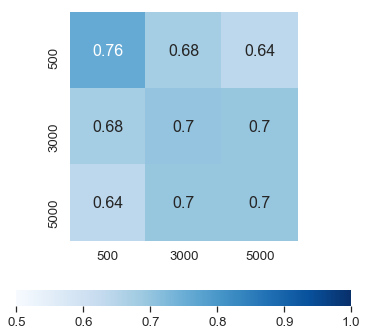

In [13]:
# read in pre-computed data and display the split-half consistency results
RES = pickle.load(open("CC_scores_splithalf_MIXED_10splits.pkl","rb"))
CC_scores_MIXED = RES['CC_scores_MIXED']
CC_scores_by_im_MIXED = RES['CC_scores_by_im_MIXED']
files_MIXED = RES['files_MIXED']

plot_confusion_matrix(CC_scores_MIXED,times)
assert(len(CC_scores_MIXED[(0,0)])==500)

## Mixed dataset split apart by dataset ## 

CAT2000Actions with 100 images


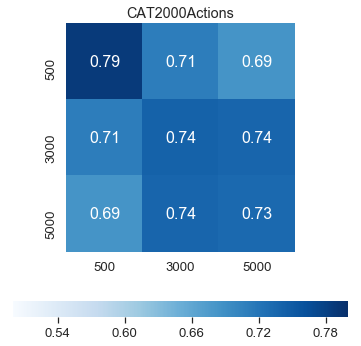

Crowd with 100 images


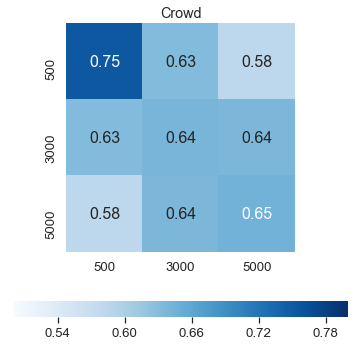

LaMem with 130 images


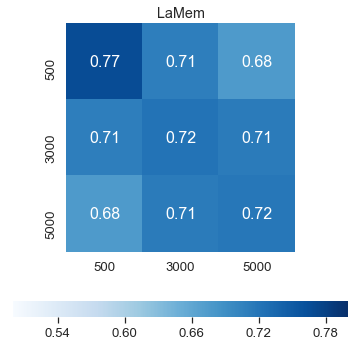

LowRes with 20 images


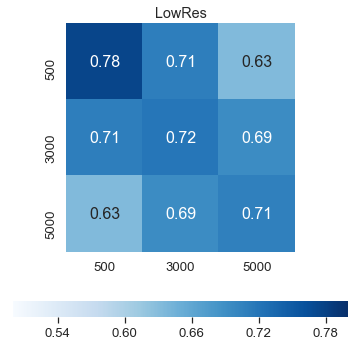

OOC with 100 images


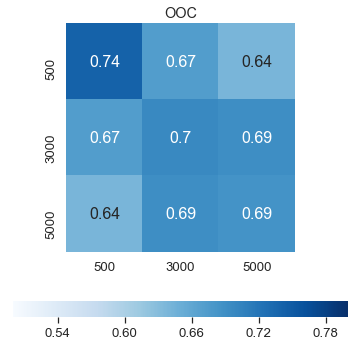

StanfordWritingActions with 50 images


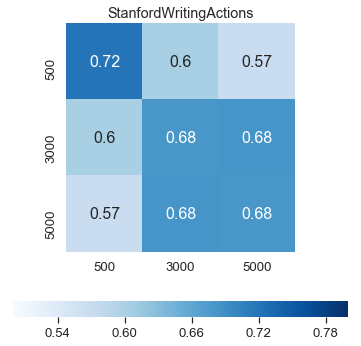

In [14]:
datasets = ["CAT2000Actions","Crowd","LaMem","LowRes","OOC","StanfordWritingActions"]

for curdataset in datasets:
    im_ids = [i for i in range(len(files_MIXED)) if curdataset in files_MIXED[i]]
    print('%s with %d images'%(curdataset,len(im_ids)))
    compute_and_plot_conf_matrix_from_inds(CC_scores_MIXED,times,im_ids,curdataset)
    

## Full CodeCharts1K dataset ##

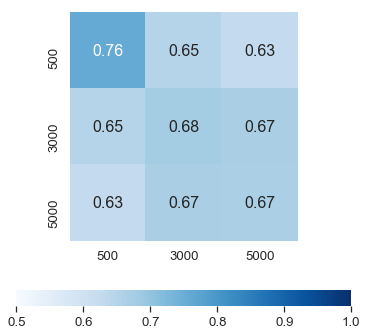

In [15]:
CC_scores_ALL = {}
for elem in CC_scores_SALICON:
    CC_scores_ALL[elem] = CC_scores_SALICON[elem].copy()
    CC_scores_ALL[elem].extend(CC_scores_MIXED[elem])
plot_confusion_matrix(CC_scores_ALL,times)
all_imnames = files_SALICON.copy()
all_imnames.extend(files_MIXED)
assert(len(CC_scores_ALL[(0,0)])==1000)

In [21]:
CC_scores_by_im_ALL = {}
for elem in CC_scores_by_im_SALICON:
    CC_scores_by_im_ALL[elem] = CC_scores_by_im_SALICON[elem]
    CC_scores_by_im_ALL[elem].extend(CC_scores_by_im_MIXED[elem])
assert(len(CC_scores_by_im_ALL[elem])==1000)

nims = len(CC_scores_ALL[(0,0)])

inds = [i for i in range(nims) if CC_scores_ALL[(0,0)][i]>CC_scores_ALL[(0,1)][i] \
                               and CC_scores_ALL[(1,1)][i]>CC_scores_ALL[(0,1)][i]]
print('%d/%d (%2.0f%%) images have different gaze patterns at 0.5 and 3 sec'\
      %(len(inds),nims,100*len(inds)/float(nims)))

inds = [i for i in range(nims) if CC_scores_ALL[(0,0)][i]>CC_scores_ALL[(0,2)][i] \
                               and CC_scores_ALL[(2,2)][i]>CC_scores_ALL[(0,2)][i]]
print('%d/%d (%2.0f%%) images have different gaze patterns at 0.5 and 5 sec'\
      %(len(inds),nims,100*len(inds)/float(nims)))

inds = [i for i in range(nims) if CC_scores_ALL[(2,2)][i]>CC_scores_ALL[(1,2)][i] \
                               and CC_scores_ALL[(1,1)][i]>CC_scores_ALL[(1,2)][i]]
print('%d/%d (%2.0f%%) images have different gaze patterns at 3 and 5 sec'\
      %(len(inds),nims,100*len(inds)/float(nims)))

AssertionError: 